In [1]:
#Variabilil globali
width = 512
height = 512

In [2]:
from AlexNet import *
from torch.utils.data.dataset import Dataset
from PIL import Image
from os import path
from torchvision import transforms
import numpy as np
import torch
from torch.utils.data import DataLoader

np.random.seed(1234)
torch.random.manual_seed(1234);

class ScenesDataset(Dataset):
    def __init__(self,base_path,txt_list,transform=None):
        #conserviamo il path alla cartella contenente le immagini
        self.base_path=base_path
        #carichiamo la lista dei file
        #sarà una matrice con n righe (numero di immagini) e 2 colonne (path, etichetta)
        self.images = np.loadtxt(txt_list,dtype=str,delimiter=',')
        #print("self.images ha i seguenti elementi:", len(self.images))
        #conserviamo il riferimento alla trasformazione da applicare
        self.transform = transform
    def __getitem__(self, index):
        #print("Get item numero -->", index)
        #recuperiamo il path dell'immagine di indice index e la relativa etichetta
        f,c = self.images[index]
        #carichiamo l'immagine utilizzando PIL e facciamo il resize a 3 canali.
        im = Image.open(path.join(self.base_path, f)).convert("RGB")
        
        #Resize:
        im = im.resize((width,height))
        #se la trasfromazione è definita, applichiamola all'immagine
        if self.transform is not None:
            im = self.transform(im)
        
        
        #convertiamo l'etichetta in un intero
        label = int(c)
        #restituiamo un dizionario contenente immagine etichetta
        return {'image' : im, 'label':label}
    #restituisce il numero di campioni: la lunghezza della lista "images"
    def __len__(self):
        #print("Ho invocato len, vale-->", len(self.images))
        return len(self.images)

In [3]:
dataset = ScenesDataset('Dataset','train.txt',transform=transforms.ToTensor())
for i in range(0, len(dataset)):
    print(dataset[i]['image'].shape, dataset[i]['label'])



torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 0
torch.Size([3, 512, 512]) 1
torch.Size([3, 512, 512]) 1
torch.Size([3, 512, 512]) 2
torch.Size([3, 512, 512]) 2


In [4]:
#Normalizziamo i dati:
#dataset = ScenesDataset('8scenes','8scenes/train.txt',transform=transforms.ToTensor())
m = np.zeros(3)
for sample in dataset:
    m+= np.array(sample['image'].sum(1).sum(1)) #accumuliamo la somma dei pixel canale per canale
#dividiamo per il numero di immagini moltiplicato per il numero di pixel
m=m/(len(dataset)*width*height)
#procedura simile per calcolare la deviazione standard
s = np.zeros(3)
for sample in dataset:
    s+= np.array(((sample['image']-torch.Tensor(m).view(3,1,1))**2).sum(1).sum(1))
s=np.sqrt(s/(len(dataset)*width*height))

In [5]:
print("Medie",m)
print("Dev.Std.",s)

Medie [0.83033568 0.70723725 0.52163703]
Dev.Std. [0.12735092 0.22173076 0.26922328]


In [6]:
transformss = transforms.Compose([transforms.ToTensor(), transforms.Normalize(m,s)])

mnist_train = ScenesDataset('Dataset','train.txt',transform=transformss)
mnist_test = ScenesDataset('Dataset','test.txt',transform=transformss)
print()
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=4, num_workers=0, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=4, num_workers=0)
print(mnist_train)

In [7]:
from torch import nn
class LeNetColor(nn.Module):
    def __init__(self):
        super(LeNetColor, self).__init__()
        #ridefiniamo il modello utilizzando i moduli sequential.
        #ne definiamo due: un "feature extractor", che estrae le feature maps
        #e un "classificatore" che implementa i livelly FC
        self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 18, 5), #Input: 3 x 32 x 32. Ouput: 18 x 28 x 28
        nn.MaxPool2d(2), #Input: 18 x 28 x 28. Output: 18 x 14 x 14
        nn.ReLU(),
        nn.Conv2d(18, 28, 5), #Input 18 x 14 x 14. Output: 28 x 10 x 10
        nn.MaxPool2d(2), #Input 28 x 10 x 10. Output: 28 x 5 x 5
        nn.ReLU()
        )
        self.classifier = nn.Sequential(
        nn.Linear(700, 360), #Input: 28 * 5 * 5
        nn.ReLU(),
        nn.Linear(360, 252),
        nn.ReLU(),
        nn.Linear(252, 100)
        )
    def forward(self,x):
        #Applichiamo le diverse trasformazioni in cascata
        x = self.feature_extractor(x)
        x = self.classifier(x.view(x.shape[0],-1))
        return x

In [8]:
net = AlexNet()
sum([p.numel() for p in net.parameters()])

57016131

In [9]:
from sklearn.metrics import accuracy_score
from torch.optim import SGD
from torch.autograd import Variable
def train_classification(model, lr=0.01, epochs=20, momentum=0.9, \
    train_loader=mnist_train_loader, test_loader=mnist_test_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(),lr, momentum=momentum)
    loaders = {'train':train_loader, 'test':test_loader}
    losses = {'train':[], 'test':[]}
    accuracies = {'train':[], 'test':[]}
    if torch.cuda.is_available():
        model=model.cuda()
    for e in range(epochs):
        #print("Primo ciclo for.")
        for mode in ['train', 'test']:
            #print("Secondo ciclo for.")
            if mode=='train':
                model.train()
            else:
                model.eval()
            epoch_loss = 0
            epoch_acc = 0
            samples = 0
            #print("Mode-->",mode)
            #print("Enumerate-->", loaders[mode])
            for i, batch in enumerate(loaders[mode]):
                #trasformiamo i tensori in variabili
                x=Variable(batch['image'], requires_grad=(mode=='train'))
                y=Variable(batch['label'])
                if torch.cuda.is_available():
                    x, y = x.cuda(), y.cuda()
                    print("Con cuda")
                #else:
                    #print("Senza cuda")
                output = model(x)
                #print(type(output))
                #print(output)
                l = criterion(output,y)
                if mode=='train':
                    l.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                #print("L-->",l.item())
                acc = accuracy_score(y.cpu().data,output.cpu().max(1)[1].data)
                epoch_loss+=l.data.item()*x.shape[0]
                epoch_acc+=acc*x.shape[0]
                samples+=x.shape[0]
                print ("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f\t\t\t\t\t" % \
                (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss/samples, epoch_acc/samples),
                epoch_loss/samples,
                epoch_acc/samples,
                losses[mode].append(epoch_loss))
                accuracies[mode].append(epoch_acc)
            #print("Fine secondo ciclo for")
        print("\r[%s] Epoch %d/%d. Iteration %d/%d. Loss: %0.2f. Accuracy: %0.2f\t\t\t\t\t" % \
        (mode, e+1, epochs, i, len(loaders[mode]), epoch_loss, epoch_acc))

    print("Ho finito.")
    #restituiamo il modello e i vari log
    return model, (losses, accuracies)

In [15]:
lenet_mnist, lenet_mnist_logs = train_classification(net, epochs=5)

[train] Epoch 1/5. Iteration 0/2. Loss: 1.10. Accuracy: 0.25					 1.0989370346069336 0.25 None
[train] Epoch 1/5. Iteration 1/2. Loss: 1.10. Accuracy: 0.17					 1.0995112657546997 0.16666666666666666 None
[test] Epoch 1/5. Iteration 0/1. Loss: 1.10. Accuracy: 0.33					 1.0981601476669312 0.3333333333333333 None
[test] Epoch 1/5. Iteration 0/1. Loss: 3.29. Accuracy: 1.00					
[train] Epoch 2/5. Iteration 0/2. Loss: 1.09. Accuracy: 0.50					 1.0947113037109375 0.5 None
[train] Epoch 2/5. Iteration 1/2. Loss: 1.10. Accuracy: 0.33					 1.0984674294789631 0.3333333333333333 None
[test] Epoch 2/5. Iteration 0/1. Loss: 1.10. Accuracy: 0.33					 1.098000407218933 0.3333333333333333 None
[test] Epoch 2/5. Iteration 0/1. Loss: 3.29. Accuracy: 1.00					
[train] Epoch 3/5. Iteration 0/2. Loss: 1.11. Accuracy: 0.00					 1.1055169105529785 0.0 None
[train] Epoch 3/5. Iteration 1/2. Loss: 1.10. Accuracy: 0.00					 1.1016132831573486 0.0 None
[test] Epoch 3/5. Iteration 0/1. Loss: 1.10. Accuracy: 0.33

In [16]:
from matplotlib import pyplot as plt
def plot_logs_classification(logs):
    training_losses, training_accuracies, test_losses, test_accuracies = \
    logs[0]['train'], logs[1]['train'], logs[0]['test'], logs[1]['test']
    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss','Test Losses'])
    plt.grid()
    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy','Test Accuracy'])
    plt.grid()
    plt.show()

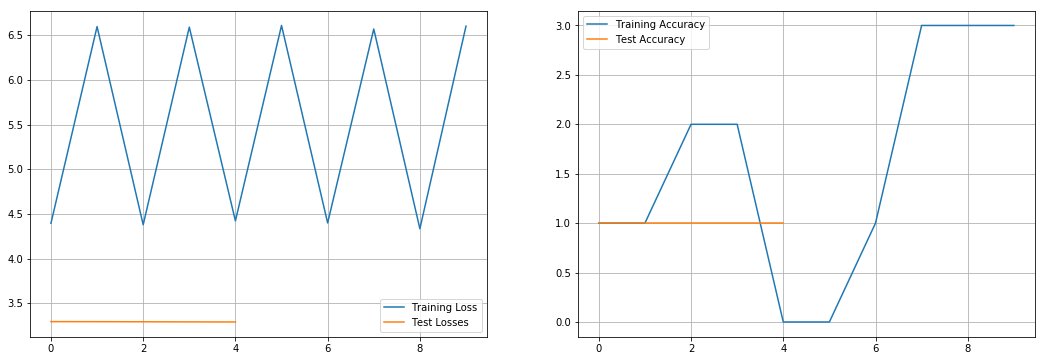

In [17]:
plot_logs_classification(lenet_mnist_logs)

In [18]:
import numpy as np
def test_model_classification(model, test_loader = mnist_test_loader):
    softmax = nn.Softmax(dim=1)
    model.eval()
    preds = []
    gts = []
    for batch in test_loader:
        x=Variable(batch["image"])
        #applichiamo la funzione softmax per avere delle probabilità
        if torch.cuda.is_available():
            x = x.cuda()
        pred = softmax(model(x)).data.cpu().numpy().copy()
        gt = batch["label"].cpu().numpy().copy()
        print("Pred-->", pred, ", gt-->", gt)
        preds.append(pred)
        gts.append(gt)
        #print(len(preds), len(gts))
    return np.concatenate(preds),np.concatenate(gts)

In [19]:
lenet_mnist_predictions, lenet_mnist_gt = test_model_classification(net)
print ("Accuracy LeNet su DIGITS: %0.2f" % \
accuracy_score(lenet_mnist_gt,lenet_mnist_predictions.argmax(1)))

Pred--> [[0.32257077 0.34484223 0.332587  ]
 [0.32305568 0.34464824 0.33229607]
 [0.3225107  0.34256816 0.33492118]] , gt--> [0 1 2]
Accuracy LeNet su DIGITS: 0.33
